In [147]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import yfinance as yf

## Data Entry
### (To-Do: Create CLI after code backtested and finalized)

In [148]:
# Import user inputs
%store -r ticker
%store -r start_date
%store -r end_date
%store -r short_window
%store -r long_window

data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


# Step 1: Define the strategy

In [149]:
# Define SMA

def SMA(data, window):
    return data.rolling(window=window).mean()

def SMA_crossover_strategy(data, short_window, long_window):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['Close']
    signals['short_SMA'] = SMA(data['Close'], short_window)
    signals['long_SMA'] = SMA(data['Close'], long_window)
    signals['signal'] = 0.0

    signals['signal'][short_window:] = np.where(signals['short_SMA'][short_window:] > signals['long_SMA'][short_window:], 1.0, 0.0)

    signals['positions'] = signals['signal'].diff()

    return signals

# Step 2: Create Strategy Dataframe

In [150]:
# Create dataframe of strategy
signals = SMA_crossover_strategy(data, short_window, long_window)
display(signals.head(150))

,price,short_SMA,long_SMA,signal,positions
Date,,,,,
2015-10-20,28.044001,NaN,NaN,0.0,NaN
2015-10-21,27.788500,NaN,NaN,0.0,0.0
2015-10-22,28.195499,NaN,NaN,0.0,0.0
2015-10-23,29.951500,NaN,NaN,0.0,0.0
2015-10-26,30.430500,NaN,NaN,0.0,0.0
...,...,...,...,...,...
2016-05-18,34.872501,34.80160,31.02916,1.0,0.0
2016-05-19,34.925999,34.99875,31.16821,1.0,0.0
2016-05-20,35.139999,35.14300,31.31208,1.0,0.0


In [151]:
# Filter the DataFrame to show only the rows with buy or sell signals
signal_data = signals.loc[signals['positions'].abs() == 1]

# display the resulting DataFrame
display(signal_data)

,price,short_SMA,long_SMA,signal,positions
Date,,,,,
2015-12-30,34.453499,33.614750,32.570550,1.0,1.0
2016-01-07,30.396999,32.859950,32.869610,0.0,-1.0
2016-03-14,28.668501,28.481600,28.404780,1.0,1.0
2016-11-04,37.752499,39.767050,40.031570,0.0,-1.0
2017-01-06,39.799500,38.363850,38.354250,1.0,1.0
2017-08-10,47.846001,49.477200,49.847070,0.0,-1.0
2017-10-11,49.750000,48.715550,48.552060,1.0,1.0
2018-04-04,70.528503,73.643101,73.733670,0.0,-1.0
2018-04-27,78.630997,75.431348,75.007660,1.0,1.0


# Step 3: Plot SMA Crossover for Selected Ticker

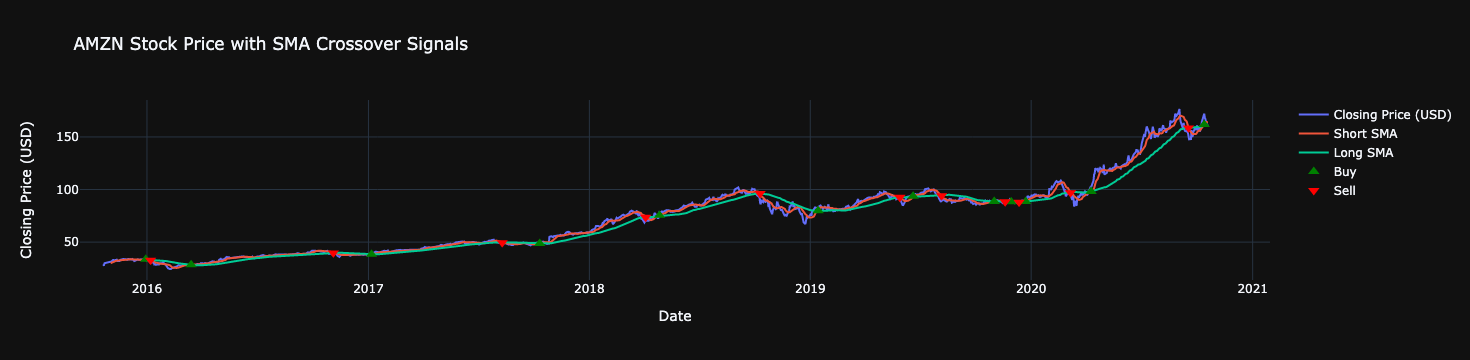

In [152]:
# Define the stock price trace
price = go.Scatter(
    x=data.index,
    y=data['Close'],
    name='Closing Price (USD)',
)

# Define the short SMA trace
short_sma = go.Scatter(
    x=signals.index,
    y=signals['short_SMA'],
    name='Short SMA',
)

# Define the long SMA trace
long_sma = go.Scatter(
    x=signals.index,
    y=signals['long_SMA'],
    name='Long SMA',
)

# Define the buy signals trace
buy_signals = go.Scatter(
    x=signals.loc[signals.positions == 1.0].index,
    y=signals.short_SMA[signals.positions == 1.0],
    name='Buy',
    mode='markers',
    marker=dict(size=10, symbol='triangle-up', color='green'),
)

# Define the sell signals trace
sell_signals = go.Scatter(
    x=signals.loc[signals.positions == -1.0].index,
    y=signals.short_SMA[signals.positions == -1.0],
    name='Sell',
    mode='markers',
    marker=dict(size=10, symbol='triangle-down', color='red'),
)

# Define the layout
layout = go.Layout(
    title=dict(text=f'{ticker} Stock Price with SMA Crossover Signals'),
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price (USD)'),
    template='plotly_dark'
)

# Create the figure
fig = go.Figure(data=[price, short_sma, long_sma, buy_signals, sell_signals], layout=layout)

# Display the figure
fig.show()

# Step 4: Measure Cumulative Returns

In [153]:
# Calculate daily returns
signals['daily_returns'] = signals['price'].pct_change()

# Calculate daily returns when following the crossover strategy
signals['strategy_returns'] = signals['daily_returns'] * signals['signal'].shift(1)

# Filter out the periods when not holding the stock (strategy_returns == 0)
holding_returns = signals[signals['strategy_returns'] != 0]['strategy_returns']
cumulative_strategy_returns = (1 + holding_returns).cumprod()

display(cumulative_strategy_returns)

Date
2015-10-20         NaN
2015-12-31    0.980873
2016-01-04    0.924420
2016-01-05    0.919776
2016-01-06    0.918122
                ...   
2020-09-17    3.460857
2020-10-14    3.380537
2020-10-15    3.355352
2020-10-16    3.289082
2020-10-19    3.223254
Name: strategy_returns, Length: 865, dtype: float64

In [154]:
# Calculate cumulative returns for buy-and-hold strategy
buy_and_hold_cumulative_returns = (1 + signals['daily_returns']).cumprod()

display(buy_and_hold_cumulative_returns)

Date
2015-10-20         NaN
2015-10-21    0.990889
2015-10-22    1.005402
2015-10-23    1.068018
2015-10-26    1.085098
                ...   
2020-10-13    6.139691
2020-10-14    5.997201
2020-10-15    5.952521
2020-10-16    5.834956
2020-10-19    5.718175
Name: daily_returns, Length: 1259, dtype: float64

# Step 5: Plot Cumulative Returns

### SMA Crossover

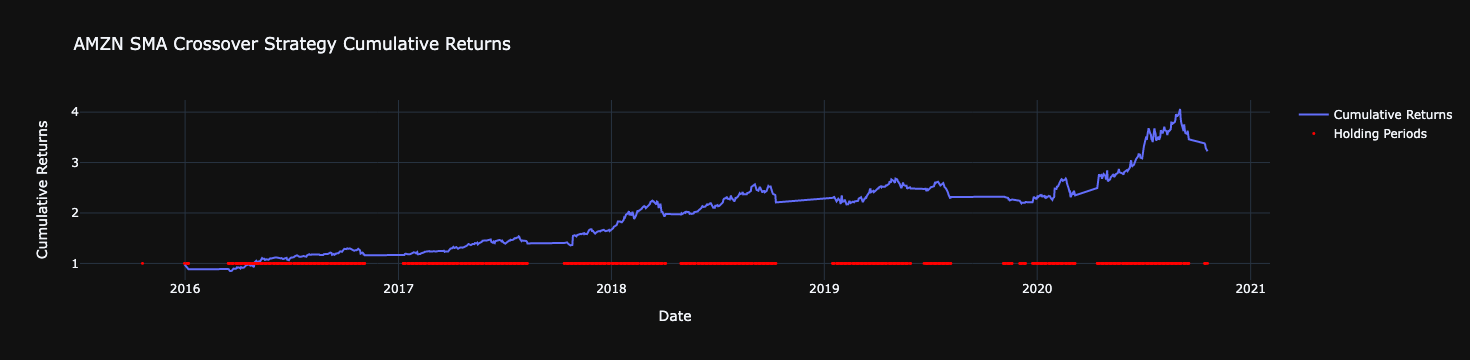

In [155]:
# Create a trace for the cumulative returns
cumulative_returns_trace = go.Scatter(
    x=cumulative_strategy_returns.index,
    y=cumulative_strategy_returns.values,
    mode='lines',
    name='Cumulative Returns'
)

# Create a trace for the holding periods
holding_periods_trace = go.Scatter(
    x=holding_returns.index,
    y=[1] * len(holding_returns),
    mode='markers',
    marker=dict(size=3, color='red'),
    name='Holding Periods'
)

# Define a layout for the chart
layout = go.Layout(
    title=dict(text=f'{ticker} SMA Crossover Strategy Cumulative Returns'),
    xaxis=dict(title='Date'),
    yaxis=dict(title='Cumulative Returns'),
    template='plotly_dark'
)

# Create the figure
fig = go.Figure(data=[cumulative_returns_trace, holding_periods_trace], layout=layout)

# Display the figure
fig.show()

### Buy and Hold

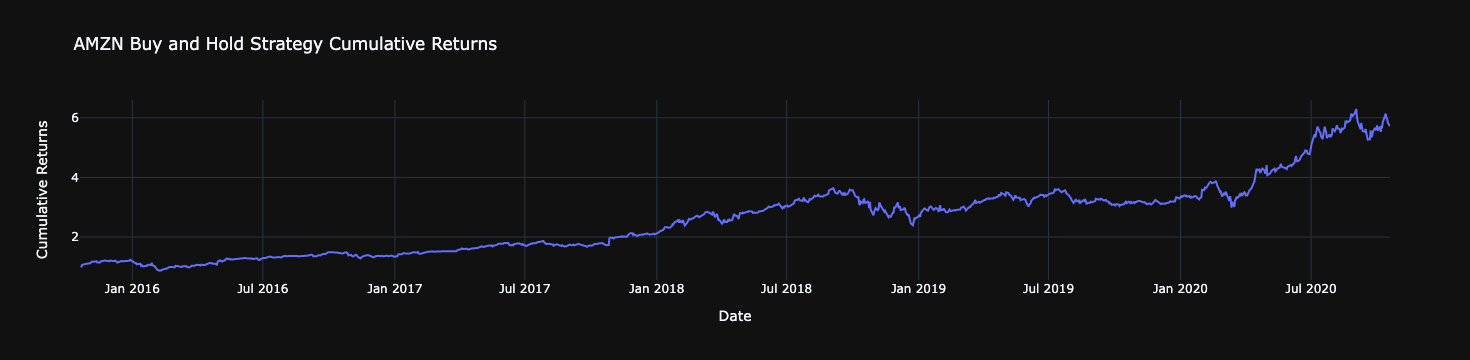

In [156]:
# Define the buy-and-hold strategy trace
buy_and_hold_cumulative_returns_trace = go.Scatter(
    x=buy_and_hold_cumulative_returns.index,
    y=buy_and_hold_cumulative_returns,
    mode='lines',
    name='Buy and Hold Strategy'
)

# Define the layout
layout = go.Layout(
    title=dict(text=f'{ticker} Buy and Hold Strategy Cumulative Returns'),
    xaxis=dict(title='Date'),
    yaxis=dict(title='Cumulative Returns'),
    template='plotly_dark'
)

# Create the figure
fig = go.Figure(data=[buy_and_hold_cumulative_returns_trace], layout=layout)

# Display the figure
fig.show()

# Step 6: Compare Returns

### Plot Comparison

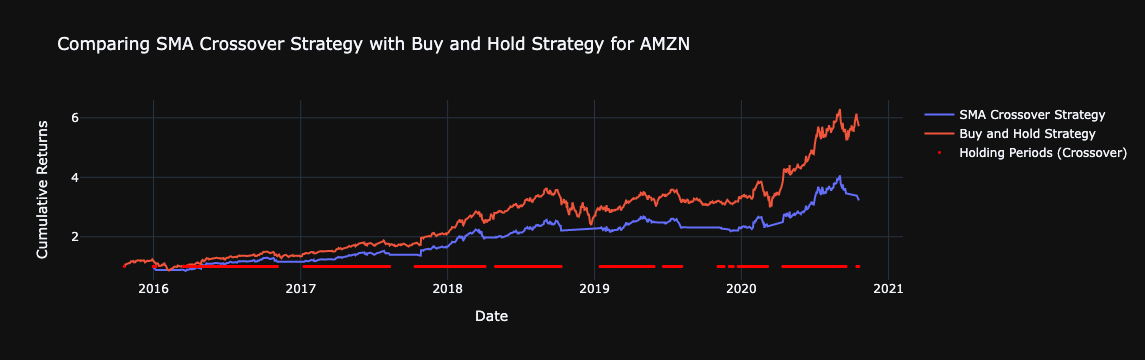

In [157]:

# Define the SMA Crossover strategy trace
sma_crossover_strategy = go.Scatter(
    x=holding_returns.index,
    y=cumulative_strategy_returns,
    mode='lines',
    name='SMA Crossover Strategy'
)

# Define the buy-and-hold strategy trace
buy_and_hold_strategy = go.Scatter(
    x=buy_and_hold_cumulative_returns.index,
    y=buy_and_hold_cumulative_returns,
    mode='lines',
    name='Buy and Hold Strategy'
)

# Define holding periods trace
holding_periods_trace = go.Scatter(
    x=holding_returns.index,
    y=[1] * len(holding_returns),
    mode='markers',
    marker=dict(size=3, color='red'),
    name='Holding Periods (Crossover)'
)

# Define the layout
layout = go.Layout(
    title=dict(text=f'Comparing SMA Crossover Strategy with Buy and Hold Strategy for {ticker}'),
    xaxis=dict(title='Date'),
    yaxis=dict(title='Cumulative Returns'),
    template='plotly_dark'
)

# Create the figure
fig = go.Figure(data=[sma_crossover_strategy, buy_and_hold_strategy, holding_periods_trace], layout=layout)

# Display the figure
fig.show()

# Step 7: Compare Risk

###  Crossover Strategy Volatility

In [158]:
# Calculate the annualized volatility
annualized_volatility_SMA = holding_returns.std() * np.sqrt(252)

# Print the standard deviation
print("Standard Deviation:", holding_returns.std())

# Print the annualized volatility
print("Annualized Volatility:", annualized_volatility_SMA)

Standard Deviation: 0.016585306015444095
Annualized Volatility: 0.2632835708086119


### Buy and Hold Strategy Volatility

In [159]:
# Calculate the annualized volatility
annualized_volatility = signals['daily_returns'].std() * np.sqrt(252)

# Print the standard deviation
print("Standard Deviation:", signals['daily_returns'].std())

# Print the annualized volatility
print("Annualized Volatility:", annualized_volatility)

Standard Deviation: 0.01907081873518508
Annualized Volatility: 0.3027398620301465


### Sharpe Ratio

In [160]:
# Calculate the Sharpe Ratio

# Calculate daily returns when holding the stock following the crossover strategy
signals['strategy_returns'] = signals['daily_returns'] * signals['signal'].shift(1)

# Calculate the average daily returns
average_daily_returns = signals['daily_returns'].mean()
average_strategy_returns = signals['strategy_returns'].mean()

# Calculate the standard deviation of daily returns (volatility)
volatility_daily_returns = signals['daily_returns'].std()
volatility_strategy_returns = signals['strategy_returns'].std()

# Set the risk-free rate (e.g., the 3-month Treasury bill rate)
risk_free_rate = 0.02 / 252  # Assume an annual risk-free rate of 2% and divide by 252 trading days

# Calculate the Sharpe ratios
sharpe_ratio_buy_and_hold = (average_daily_returns - risk_free_rate) / volatility_daily_returns
sharpe_ratio_strategy = (average_strategy_returns - risk_free_rate) / volatility_strategy_returns

# Print the Sharpe ratios
print("Sharpe Ratio (Buy and Hold Strategy):", sharpe_ratio_buy_and_hold)
print("Sharpe Ratio (SMA Crossover Strategy):", sharpe_ratio_strategy)


Sharpe Ratio (Buy and Hold Strategy): 0.07805655528962391
Sharpe Ratio (SMA Crossover Strategy): 0.06870080932096075


### Sortino Ratio

In [161]:
# Calculate the Sortino Ratio

# Calculate the downside deviations (considering only negative returns)
downside_deviation_daily_returns = signals[signals['daily_returns'] < 0]['daily_returns'].std()
downside_deviation_strategy_returns = signals[signals['strategy_returns'] < 0]['strategy_returns'].std()

# Set the risk-free rate (e.g., the 3-month Treasury bill rate)
risk_free_rate = 0.02 / 252  # Assume an annual risk-free rate of 2% and divide by 252 trading days

# Calculate the Sortino ratios
sortino_ratio_buy_and_hold = (average_daily_returns - risk_free_rate) / downside_deviation_daily_returns
sortino_ratio_strategy = (average_strategy_returns - risk_free_rate) / downside_deviation_strategy_returns

# Print the Sortino ratios
print("Sortino Ratio (Buy and Hold Strategy):", sortino_ratio_buy_and_hold)
print("Sortino Ratio (SMA Crossover Strategy):", sortino_ratio_strategy)


Sortino Ratio (Buy and Hold Strategy): 0.10911313826135594
Sortino Ratio (SMA Crossover Strategy): 0.08223660898062199


# Step 8: Create Plot for Comparison of Volatilities/Ratios

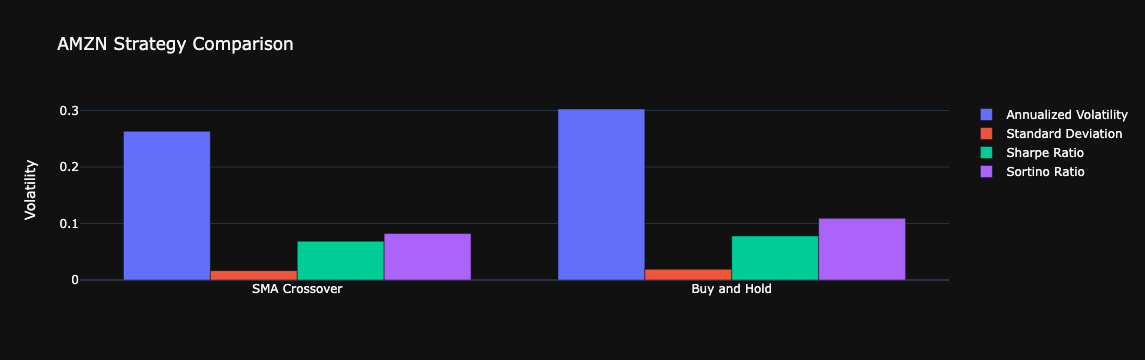

In [167]:
# Create a bar chart of annualized volatility, standard deviation, Sharpe ratio, and Sortino ratio
fig = go.Figure()
fig.add_trace(go.Bar(x=["SMA Crossover", "Buy and Hold"],
                     y=[annualized_volatility_SMA, annualized_volatility],
                     name='Annualized Volatility'))
fig.add_trace(go.Bar(x=["SMA Crossover", "Buy and Hold"],
                     y=[holding_returns.std(), signals['daily_returns'].std()],
                     name='Standard Deviation'))
fig.add_trace(go.Bar(x=["SMA Crossover", "Buy and Hold"],
                     y=[sharpe_ratio_strategy, sharpe_ratio_buy_and_hold],
                     name='Sharpe Ratio'))
fig.add_trace(go.Bar(x=["SMA Crossover", "Buy and Hold"],
                     y=[sortino_ratio_strategy, sortino_ratio_buy_and_hold],
                     name='Sortino Ratio'))

fig.update_layout(title=f'{ticker} Strategy Comparison', barmode='group',
                  yaxis=dict(title='Volatility'), template='plotly_dark')

fig.show()